In [44]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import pandas as pd
import glob
import datetime

from utils import TrainingSetManager
from utils import TeenmagiDataset

import time

import random
from random import shuffle
import math

import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import Sequence

import imgaug as ia
import imgaug.augmenters as iaa

from os import walk
import pickle
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

from tempfile import TemporaryFile

from IPython.display import clear_output
from tqdm.notebook import tqdm

from utils import DatasetManipulation as dm
from keyword import iskeyword

import threading

In [45]:
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

## Loading datasets

In [46]:
with open("data/training_x.dat", 'rb') as pickleFile:
    training_x = pickle.load(pickleFile)
with open("data/training_y.dat", 'rb') as pickleFile:
    training_y = pickle.load(pickleFile)
with open("data/validation_x.dat", 'rb') as pickleFile:
    validation_x = pickle.load(pickleFile)

# deleting broken img and index of it
del training_y[216805]
del training_x[216805]

# str to int
training_y = [int(x) for x in training_y]
training_x = np.array(training_x)
training_y = np.array(training_y)
validation_x = np.array(validation_x)

In [47]:
#print("Image categories\n", np.array(list(set(training_y))))

In [48]:
def image_viewer(dataset_x: np.array, dataset_y: np.array=[], title="", img_class: int=None):
    n = 10
    
    plt.figure(figsize=(20, 7))
    for i in range(n):
        # display reconstruction
        if img_class != None:
            cimg = np.where(dataset_y == img_class)
            image_index = np.random.choice(cimg[0])
        else:
            image_index = np.random.randint(len(dataset_x))
        
        #print("image_index", image_index, len(dataset_y))
        bx = plt.subplot(3, n, i + n + 1)
        
        if len(dataset_y) > 0:
            tmp_img_class = img_class if img_class != None else dataset_y[image_index]
            plt.title(title + "\n" + str(tmp_img_class) + " "+ str(image_index))
        else:
            plt.title(title + "\n" + str(image_index))
        
        plt.imshow(tf.squeeze(dataset_x[image_index]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)

    plt.show()

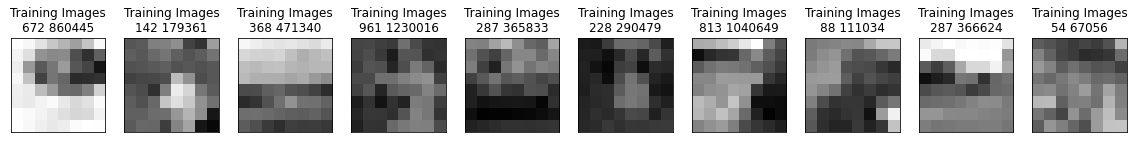

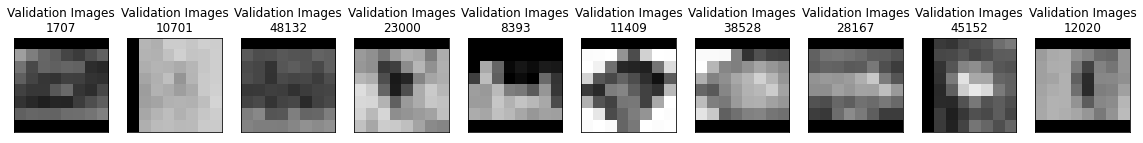

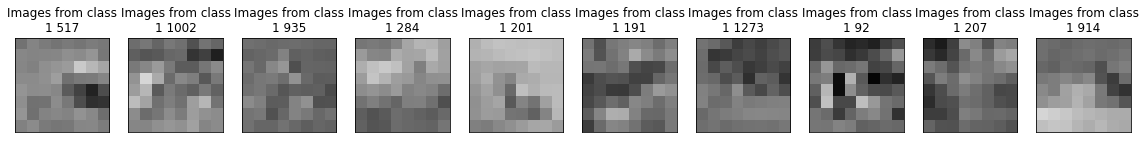

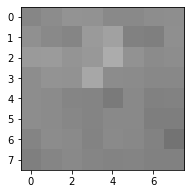

In [49]:
image_viewer(training_x, training_y, title="Training Images")
image_viewer(validation_x, title="Validation Images")

image_viewer(training_x, training_y, title="Images from class", img_class=1)

plt.figure(figsize=(3, 3))
plt.imshow(training_x[1270506])

In [50]:
# Finding images in different rotations. Using hash for faster accessable

def hash_find_dict(hash_dict: dict, tofind_matrix: np.array):
    indices = []
    for k in range(1, 4):
        tofind = np.rot90(tofind_matrix, k=k).flatten().tolist()
        tofind = hash(tuple(tofind))
        if tofind in hash_dict:
            return True
                
    return False

"""
founded = []
training_x_hash_dict = {}
for i in range(len(training_x)):
    tmp_hash = tuple(training_x[i].flatten().tolist())
    tmp_hash = hash(tmp_hash)
    training_x_hash_dict[tmp_hash] = i 

        
for to_rotate in tqdm(training_x):
    found = hash_find_dict(training_x_hash_dict, training_x[0])
    founded.append(found)

founded = np.array(founded)
print("Founded similar images with different rotations:", len(founded[founded==True]))
"""

'\nfounded = []\ntraining_x_hash_dict = {}\nfor i in range(len(training_x)):\n    tmp_hash = tuple(training_x[i].flatten().tolist())\n    tmp_hash = hash(tmp_hash)\n    training_x_hash_dict[tmp_hash] = i \n\n        \nfor to_rotate in tqdm(training_x):\n    found = hash_find_dict(training_x_hash_dict, training_x[0])\n    founded.append(found)\n\nfounded = np.array(founded)\nprint("Founded similar images with different rotations:", len(founded[founded==True]))\n'

#### Preparing and clearing dataset using different methods 

In [51]:
# Reshaping and Grayscaling images from shape (8,8,3) to (8,8,1)
greyscale_training_x = dm.Grayscale(training_x, normalize=False)

# Removing duplicates 
#  - TODO: implement similar data deletation in different rotations
greyscale_training_x, greyscale_training_y, uindices = dm.RemoveDuplicates(greyscale_training_x, training_y)
# TODO greyscale enchantments

print("Duplicates removed:", len(training_x) - len(greyscale_training_x))

Grayscaling images:   0%|          | 0/1281166 [00:00<?, ?it/s]

Duplicates removed: 5980


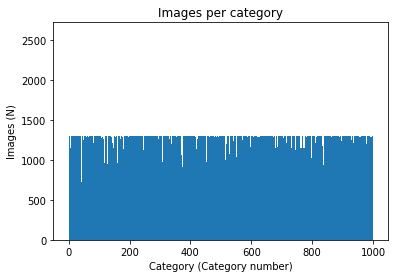

Lowest image count in category: 728


In [52]:
tmp_bins = [0] + list(set(greyscale_training_y))
counts, bins = np.histogram(greyscale_training_y, bins=np.array(tmp_bins))
plt.hist(bins[:-1], bins, weights=counts)
plt.title("Images per category")
plt.ylabel("Images (N)")
plt.xlabel("Category (Category number)")
plt.show()
print("Lowest image count in category:", min(counts[1:]))

As seen in histogram training data is not evenly distibuted. Therefore other categories will get dominant in uniformal training process.

Therefore, custom training list-class is nessecery to have stable training for each category.

In [53]:
class TrainingData(Sequence):
    """
    0 index is always added to training_classes
    - 0 marks as undenified images
    
    When using custom training_classes example from [5, 7, 10, 11]
     5 is marked as 1; 
     7 is marked as 2; 
    10 is marked as 3 etc.
    """
    def __init__(self, 
                 training_x: np.array,
                 training_y: np.array,
                 training_categories: list=[i+1 for i in range(1000)],
                 
                 batch_size: int=32,
                 use_logits=True, # TODO
                ):
        
        # Variables for machine learning model
        self.epoch_length = int(10e3)
        self.batch_size = batch_size
        self.use_logits = use_logits
        self.evaluation_size = 0.1 # procents to evaluate in cat
        
        # Training set
        self.training_set = [[] for i in range(1 + len(set(training_y)))]
        self.evaluation_set = [[] for i in range(1 + len(set(training_y)))]
        for ci in set(training_y):
            cimgs_indices = np.where(training_y==ci)[0]
            # shuffle
            p = np.random.permutation(len(cimgs_indices))
            cimgs_indices = cimgs_indices[p]
            
            tmp_evals = 100
            tmp_evals = -1 if tmp_evals == 1 else tmp_evals
            cimgs_itrain, cimgs_ieval = cimgs_indices[:-tmp_evals], cimgs_indices[-tmp_evals:]
            
            self.training_set[ci] = training_x[cimgs_itrain]
            self.evaluation_set[ci] = cimgs_ieval
            
        # defines which categories are trained.
        # 0 is a wild-card which includes all classes which are not included
        self.training_classes = np.array([])
        self.zero_categories = []
        self.set_training_categories(training_categories)
        
        ## Multiprocessing workers
        #operators = [threading.Thread(target=self.__generate_item, args=(0)) for i in range(2)]
        #self.datafeed = []
        
        # Stats
        self.stats = None
        self.reset_stats()
        
    def reset_stats(self):
        self.stats = np.zeros((len(self.training_set),), dtype=int)
        
    def evaluation(self):
        tmp_x = [np.array(cimgs) for cimgs in self.evaluation_set]
        tmp_y = [np.full(len(cimgs), idx) for idx, cimgs in enumerate(self.evaluation_set)]
        
        tmp_x = np.concatenate(tmp_x, axis=0)
        tmp_y = np.concatenate(tmp_y, axis=0)
            
        return (tmp_x, tmp_y)
    
    def set_training_categories(self, categories: list):
        """
        0 will be included all times to front
        """
        self.zero_categories = []
        self.training_classes = [0] + categories
        
        all_cats = np.array([i for i in range(len(self.training_set))])
        self.zero_categories = np.delete(all_cats, self.training_classes)
        
    def plot_trainingset(self):
        plt.title("Training category image counts")
        x_plot = [len(x) for x in self.training_set]
        print(np.array(x_plot))
        plt.stairs(x_plot, fill=True)
        plt.show()
        
    def plot_stats(self):
        plt.title("Trained categories stats")
        plt.stairs(self.stats, fill=True)
        plt.show()
    
    def output_size(self):
        return len(self.training_classes)
    
    def __worker(self):
        while True:
            if len(self.datafeed) < 10:
                for i in range(20):
                    batch_x, batch_y = self.__generate_item()
                    self.datafeed.append((np.array(batch_x), np.array(batch_y)))
            time.sleep(1)
        
    def __generate_item(self):
        include_all = True if len(self.training_classes) == len(self.training_set) else False

        if include_all:
            tmp_batch_y = np.random.choice(self.training_classes[1:], size=self.batch_size)
        else:
            tmp_batch_y = np.random.choice(self.training_classes, size=self.batch_size)

        batch_x = []
        batch_y = []
        for ci in tmp_batch_y:
            category_index = ci #if include_all else np.random.choice(self.zero_categories)

            cimg_index = np.random.randint(0, high=len(self.training_set[category_index]), size=None, dtype=int)
            batch_x.append(self.training_set[category_index][cimg_index])

            # set image to correspond to Y
            # asd = np.where(self.training_classes==ci)[0][0] if ci == category_index else 0
            y_tmp = np.zeros( (len(self.training_classes)) )
            y_tmp[category_index] = 1
            batch_y.append(y_tmp)
            self.stats[category_index] += 1
                
        return np.array(batch_x), np.array(batch_y)
    
    def __len__(self):
        return self.epoch_length
    
    def __getitem__(self, idx) -> (np.array, np.array):
        return self.__generate_item()

### benchnmarking datafeed

  0%|          | 0/10000 [00:00<?, ?it/s]

[   0 1200 1200 ... 1198 1199 1192]


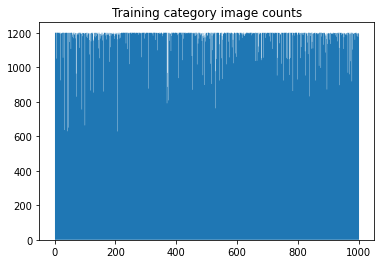

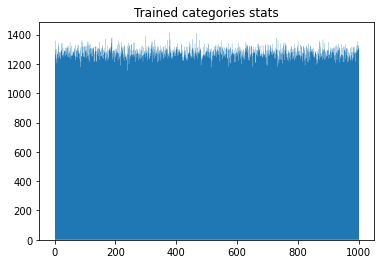

In [30]:
test_dataset = TrainingData(greyscale_training_x, greyscale_training_y, batch_size=128)

for i in tqdm(range(10000)):
    tmp_x, tmp_y = test_dataset[0]
    tmp_x = tmp_x[0] * 255
    tmp_x = tmp_x.astype(int)

test_dataset.plot_trainingset()
test_dataset.plot_stats()

# Machine learning

In [31]:
# Layers

initializer = lambda : initializers.RandomUniform(minval=-2, maxval=2)

dense_layer = lambda x, y : layers.Dense(x, activation=y,
                                               kernel_initializer=initializer(),
                                               bias_initializer=initializer(),
                                              )

conv2d_layer = lambda filters : layers.Conv2D(
                            filters, (3,3), padding='same', activation='relu',
                            #kernel_initializer=initializer(),
                            #bias_initializer=initializer()
                            )

def CropPad(x):
    if np.random.rand() <= 0.1:
        c = np.random.randint(1,3)
        if np.random.rand() <= 0.5:
            x = tf.keras.layers.Cropping2D(cropping=((c, c), (0, 0)))(x)
            x = tf.keras.layers.ZeroPadding2D(padding=((c, c), (0, 0)))(x)
        else:
            x = tf.keras.layers.Cropping2D(cropping=((0, 0), (c, c)))(x)
            x = tf.keras.layers.ZeroPadding2D(padding=((0, 0), (c, c)))(x)
    return x

#### Custom model

In [55]:
# Creating custom machine learning model where first layer has data_augmented layer
# augmented layer is taken off 
class MasterModel(Model):
    def __init__(self, augmentation=True, name=None, output_size=1000):
        super(MasterModel, self).__init__(name=name)
        
        self.augmentation = augmentation
        
        self.data_augmentation = tf.keras.Sequential(
          [
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
            layers.Lambda(CropPad),
          ]
        )
        
        self.base_model = tf.keras.Sequential([
            layers.Input(shape=(8, 8, 1)),
            layers.Conv2D(64, (3,3), padding='same', activation='gelu'),
            layers.MaxPooling2D(),
            
            layers.Flatten(),
            layers.Dropout(0.2),
            dense_layer(512, 'gelu'),
            
            layers.Dense(output_size)        
        ])
            
    def test_step(self, data):
        print("\ntest_step")
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self.call_eval(x, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}
            
    def call_eval(self, x, training=False):
        x = self.base_model(x, training=training)
        return x
            
    def call(self, x, training=True):
        #x = self.input_layer(x)
        if self.augmentation:
            x = self.data_augmentation(x, training=training)
        x = self.base_model(x, training=training)
        return x

In [60]:
MODEL_COUNT = 1
FROM_LOGITS = True
SPARSE      = False

"""
Generating models and sub-models between different categories
"""

CATEGORYS_PER_STEP = int(1000/MODEL_COUNT)
MODEL_NAME = "correlation_" + str(MODEL_COUNT)
TMP = glob.glob("models/" + MODEL_NAME + "*")
MODEL_NAME = MODEL_NAME + "_" + str(len(TMP)) + "_test"
MODEL_PATH = "models/correlation_" + str(MODEL_COUNT) + ("_SPARSE" if SPARSE else "_NSPARSE") + "/"

OUTPUT_SIZE = CATEGORYS_PER_STEP + 1 #dataset_manager.output_size()

models = []
for i in range(MODEL_COUNT):
    model_name ="correlation_" + str(i + 1) + "_master"
    tmp_model = MasterModel(name=model_name, 
                            output_size=OUTPUT_SIZE
                           )
    
    tmp_model.compile(
                optimizer= keras.optimizers.Adam(learning_rate=0.005), #0.001
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    
    models.append(tmp_model)
            
#models[0].summary()

In [ ]:
START_MODEL_I = 0 #54

dataset_manager = TrainingData(greyscale_training_x, greyscale_training_y, batch_size=128)

for i in range(START_MODEL_I, len(models)):
    #model_name ="correlation_" + str(i + 1)
    
    """
    CALLBACKS
    """
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor='accuracy', 
                                                  factor=0.7,
                                                  patience=3,
                                                  min_lr=1e-4, 
                                                  verbose=0,
                                                  min_delta=0.005,
                                                  cooldown=3,
                                                )

    model_weight_path =  MODEL_PATH + models[i].name
    
    early_stopping = keras.callbacks.EarlyStopping(patience=6, monitor='accuracy')
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        model_weight_path, save_best_only=True, monitor='accuracy', verbose=0)
    
    model_checkpoint_val = tf.keras.callbacks.ModelCheckpoint(
        model_weight_path + "_val", save_best_only=True, monitor='val_accuracy', verbose=0)
    
    """
    Training parameters for model
    """
    
    start = i * CATEGORYS_PER_STEP + 1
    end = start + CATEGORYS_PER_STEP
    categories = [i for i in range(start, end)]
    
    print("Model", i + 1, "-", models[i].name, model_weight_path)
    print(" categories from", categories[0], "to", categories[-1])
    
    tmp_training_dataset = TrainingData(
                                greyscale_training_x, 
                                greyscale_training_y, 
                                #training_categories=categories,
                                batch_size=128)
    
    # Manually set learning rate
    #K.set_value(models[i].optimizer.learning_rate, 0.0005) #1e-4)
    
    first_time = datetime.datetime.now()
    history = models[i].fit(tmp_training_dataset,
                                   epochs=20,
                                   validation_data = tmp_training_dataset.evaluation(),
                                   #validation_data=teenmagi_dataset.validation_set(only_categories=False),
                                   #steps_per_epoch=400,
                                   #verbose=0,
                                      callbacks=[
                                           reduce_lr,
                                           early_stopping,
                                           #model_checkpoint,
                                           #model_checkpoint_val,
                                       ])
    evaluate_set = teenmagi_dataset.validation_set(only_categories=True)
    a,b = dataset_manager.evaluation_set()
    models[i].evaluate(a, b)

    training_set_manager.plot_history(history)
    difference = datetime.datetime.now() - first_time
    print("  stopped at epoch", len(history.history['accuracy']))
    print("  latest accuracy:", history.history['accuracy'][-1])
    if 'val_accuracy' in history.history:
        print("  best val_accuracy:", max(history.history['val_accuracy']))
    print("  time left est:", (len(models) - i) * difference)
    #teenmagi_dataset.info()

In [ ]:
accuracies = []
for i, tmp_model in enumerate(models):
    start = i * CATEGORYS_PER_STEP + 1
    end = start + CATEGORYS_PER_STEP
    categories = [i for i in range(start, end)]
    
    teenmagi_dataset = TeenmagiDataset(categories=categories, 
                                   batch_size=64, 
                                   n_valid=100,
                                   sparse=SPARSE,
                                   #zero_percentage=0.2
                                  )
    (x, y) = dataset_manager.evaluation_set() #teenmagi_dataset.validation_set(only_categories=True)
    [loss, accuracy] = tmp_model.evaluate(x, y, verbose=0)
    accuracies.append(accuracy)
    print("Model:", i, "- accuracy:", round(accuracy, 4) , "- loss:", loss)

print("Total accuracy:", sum(accuracies)/len(accuracies))

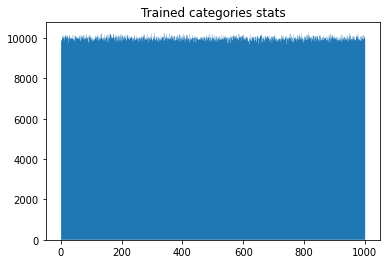

In [21]:
tmp_training_dataset.plot_stats()

### - Confusion matrix plotting

In [ ]:
#(_, confusion_set, _) = (termi_train, termi_valid, termi_test) #training_set_manager.gen_training_set(
        #categories=[i+1 for i in range(1000)],
    #)
#training_set_manager.plot(confusion_set[1])
confusion_set = dataset_manager.evaluation_set()#teenmagi_dataset.validation_set(only_categories=False)
a,b = confusion_set
#models[i].evaluate(a, b)

In [ ]:
predictions = models[i].predict(a) #models[0].predict(confusion_set[0])
predictions_arg = tf.argmax(predictions, axis=-1)
print(len(predictions[0]))
print(predictions_arg)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(tf.argmax(b, axis=-1), predictions_arg)
confusion_mtx = confusion_mtx.numpy() #np.amax(predictions_arg)
#confusion_mtx[confusion_mtx < 0.4] = 0
print(confusion_mtx.shape)

In [ ]:
heatmap_filepath = "heatmaps/heatmap_" + str(OUTPUT_SIZE)
cconfusion_mtx = confusion_mtx / 1
cconfusion_mtx = np.clip(cconfusion_mtx, a_min=0, a_max=1)

img = cconfusion_mtx# np.rot90(confusion_mtx, k=1, axes=(0, 1)) # /asd #* 255
img = np.reshape(img, (OUTPUT_SIZE, OUTPUT_SIZE))

tmp = glob.glob(heatmap_filepath + "*")
plt.figure(figsize=(40, 40))

matplotlib.image.imsave(heatmap_filepath + "_" + str(len(tmp)) + ".png", img)

plt.imshow(img)
plt.gray()
#plt.savefig(heatmap_filepath + "_" + str(len(tmp)) + ".png")

# Combined Model

In [ ]:
correlation_models = [2, 25]

TRAINABLE=False
C_SPARSE = False
use_best_val = False

In [ ]:
models = []
for model_size in correlation_models:
    root_folder = "models/correlation_" + str(model_size) + "_NSPARSE"
    model_paths = glob.glob(root_folder + "/*[!val]") #("/*[val]" if use_best_val else "/*[!val]") )
    print("model_size:", model_size, "found",len(model_paths))
    
    #Loading models
    for i, model_path in enumerate(tqdm(model_paths)):
        tmp_model = tf.keras.models.load_model(model_path)
        tmp_model._name = "correlation_" + str(model_size) + "_" + str(i)
        tmp_model.trainable = TRAINABLE
        models.append(tmp_model)

In [ ]:
#models = models[:50]

# SETTINGS
MODEL_COUNT_TERMI = len(models)
CATEGORYS_PER_STEP_TERMI = int(1000/MODEL_COUNT_TERMI)

OUTPUT_SIZE = CATEGORYS_PER_STEP_TERMI*len(models) + 1 if len(models) != 100 else 1000
OUTPUT_SIZE = 1000
print("OUTPUT_SIZE:", OUTPUT_SIZE)

In [ ]:
# Input
image_input = keras.Input(shape=(8,8,1), name="image")
outputs = []

for model in models:
    x = model(image_input, training=TRAINABLE)
    outputs.append(x)
    
x = layers.concatenate(outputs)

#x=layers.Dropout(0.2)(x)
#x=layers.Dense(64, activation='relu', kernel_regularizer='l1_l2')(x)
x=layers.Dense(1000, use_bias=False, activation='relu')(x)
#x=layers.Dense(1000, activation='relu')(x)

output = layers.Dense(OUTPUT_SIZE, use_bias=False)(x)

model_terminator = keras.Model(inputs=image_input, outputs=output, name="terminator_classifier")

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_terminator.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

try:
    model_terminator = tf.keras.models.load_model("models/terminator_" + str(correlation_models[0]) + "_latest")
    print("Model loaded")
except:
    pass

model_terminator.summary()

In [ ]:
def set_trainability(model): # Takes keras Model and dictionary with layer names and booleans indicating the desired trainability of the layer. 
                                         # modifies model so that every Layer in the Model, whose name matches dict key will get trainable = boolean
    for layer in model.layers: 
        if isinstance(layer, tf.keras.models.Model):
            set_trainability(layer)
        else: 
            layer.trainable = True
                                 
set_trainability(model_terminator)

model_terminator.summary()

In [ ]:
termi_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor='accuracy', 
                                              factor=0.6,
                                              patience=3,
                                              min_lr=1e-6, 
                                              verbose=0,
                                              min_delta=0.01,
                                              cooldown=3,
                                            )
teenmagi_dataset_comb = TeenmagiDataset(#categories=categories, 
                                        batch_size=256, 
                                        n_valid=50,
                                        sparse=False,
                                        master_model=True,
                                       #zero_percentage=0.1
                                      )

#early_stopping = keras.callbacks.EarlyStopping(patience=10, monitor='accuracy')

model_weight_path = "models/terminator_" + str(correlation_models[0]) + "_latest"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_weight_path, save_best_only=True, monitor='accuracy', verbose=0)

K.set_value(model_terminator.optimizer.learning_rate, 1e-5)

history = model_terminator.fit(teenmagi_dataset_comb,
                               #termi_train[0], termi_train[1],                            
                               epochs=100, 
                               #validation_data=teenmagi_dataset_comb.validation_set(),
                               #steps_per_epoch=200,
                               #shuffle=True,
                               #verbose=0,          
                                  callbacks=[
                                       termi_reduce_lr,
                                       #early_stopping,
                                       model_checkpoint,
                                       ]
                       )

# 0.0457
# 0,0481

In [ ]:
predictions = training_set_manager.validate_model(model_terminator)

df = predictions[0]
tmp = np.array(df['Class'])
tmp += 1
df['Class'] = tmp
df

In [ ]:
df.to_csv("hello.csv")